In [1]:
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10, 8)
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import collections
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from ipywidgets import Image
from io import StringIO
import pydotplus

In [2]:
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])],
                     axis=1)
    out.drop(feature_list, axis=1, inplace=True)
    return out


def intersect_features(train, test):
    common_feat = list(set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

In [3]:
features = ['Looks', 'Alcoholic_beverage','Eloquence','Money_spent']

In [4]:
df_train = {}
df_train['Looks'] = ['handsome', 'handsome', 'handsome', 'repulsive',
                         'repulsive', 'repulsive', 'handsome'] 
df_train['Alcoholic_beverage'] = ['yes', 'yes', 'no', 'no', 'yes', 'yes', 'yes']
df_train['Eloquence'] = ['high', 'low', 'average', 'average', 'low',
                                   'high', 'average']
df_train['Money_spent'] = ['lots', 'little', 'lots', 'little', 'lots',
                                  'lots', 'lots']
df_train['Will_go'] = LabelEncoder().fit_transform(['+', '-', '+', '-', '-', '+', '+'])

df_train = create_df(df_train, features)
df_train

,Will_go,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Eloquence_low,Money_spent_little,Money_spent_lots
0,0,1,0,0,1,0,1,0,0,1
1,1,1,0,0,1,0,0,1,1,0
2,0,1,0,1,0,1,0,0,0,1
3,1,0,1,1,0,1,0,0,1,0
4,1,0,1,0,1,0,0,1,0,1
5,0,0,1,0,1,0,1,0,0,1
6,0,1,0,0,1,1,0,0,0,1


In [5]:
df_test = {}
df_test['Looks'] = ['handsome', 'handsome', 'repulsive'] 
df_test['Alcoholic_beverage'] = ['no', 'yes', 'yes']
df_test['Eloquence'] = ['average', 'high', 'average']
df_test['Money_spent'] = ['lots', 'little', 'lots']
df_test = create_df(df_test, features)
df_test

,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Money_spent_little,Money_spent_lots
0,1,0,1,0,1,0,0,1
1,1,0,0,1,0,1,1,0
2,0,1,0,1,1,0,0,1


In [6]:
y = df_train['Will_go']
df_train, df_test = intersect_features(train=df_train, test=df_test)
df_train

,Looks_repulsive,Looks_handsome,Alcoholic_beverage_yes,Money_spent_little,Eloquence_average,Money_spent_lots,Alcoholic_beverage_no,Eloquence_high
0,0,1,1,0,0,1,0,1
1,0,1,1,1,0,0,0,0
2,0,1,0,0,1,1,1,0
3,1,0,0,1,1,0,1,0
4,1,0,1,0,0,1,0,0
5,1,0,1,0,0,1,0,1
6,0,1,1,0,1,1,0,0


In [7]:
df_test

,Looks_repulsive,Looks_handsome,Alcoholic_beverage_yes,Money_spent_little,Eloquence_average,Money_spent_lots,Alcoholic_beverage_no,Eloquence_high
0,0,1,0,0,1,1,1,0
1,0,1,1,1,0,0,0,1
2,1,0,1,0,1,1,0,0


In [8]:
def tree_to_png(tree, feature_names, filename):
    tree_str = export_graphviz(tree, feature_names=feature_names,
                               filled=True, out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str)
    graph.write_png(filename)

In [9]:
def entropy(a_list):
    d = {}
    for e in a_list:
        if e not in d:
            d[e] = 0
        d[e] += 1
    s = 0
    n = len(a_list)
    for v in d.values():
        s += -(v / n * np.log2(v / n))
    return s

In [10]:
s0 = entropy(y)
print(f'S0: {s0}')

S0: 0.9852281360342515


In [11]:
df_train_targ = pd.concat([df_train, y], axis=1)
df_1 = df_train_targ[df_train_targ['Looks_handsome'] == 1]
df_2 = df_train_targ[df_train_targ['Looks_handsome'] == 0]
s1 = entropy(df_1['Will_go'])
s2 = entropy(df_2['Will_go'])
N1 = df_1.shape[0]
N2 = df_2.shape[0]
N = df_train.shape[0]
print(f'S1: {s1}')
print(f'S2: {s2}')
print(f'IG: {s0 - s1 * N1 / N - s2 * N2 / N}')

S1: 0.8112781244591328
S2: 0.9182958340544896
IG: 0.12808527889139437


In [12]:
tree = DecisionTreeClassifier(criterion='entropy')
tree.fit(df_train, y);
tree_to_png(tree, df_train.columns, 'topic3_assignment.png')

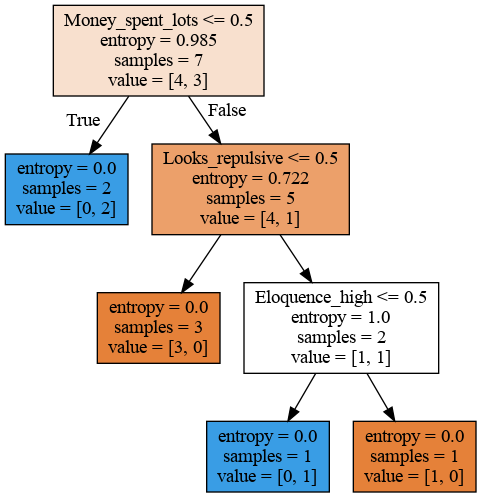

In [13]:
from IPython.display import Image
Image(filename='topic3_assignment.png')

In [14]:
balls = [1 for i in range(9)] + [0 for i in range(11)]

balls_left = [1 for i in range(8)] + [0 for i in range(5)]

balls_right = [1 for i in range(1)] + [0 for i in range(6)]

In [15]:
print(entropy(balls)) # 9 blue и 11 yellow
print(entropy(balls_left)) # 8 blue и 5 yellow
print(entropy(balls_right)) # 1 blue и 6 yellow
print(entropy([1,2,3,4,5,6])) # entropy of a fair 6-sided die

0.9927744539878083
0.9612366047228759
0.5916727785823275
2.584962500721156


In [16]:
def information_gain(root, left, right):
    N = len(root)
    N1 = len(left)
    N2 = len(right)
    S0 = entropy(root)
    S1 = entropy(left)
    S2 = entropy(right)
    return S0 - N1 / N * S1 - N2 / N * S2

In [17]:
print(f'IG: {information_gain(balls, balls_left, balls_right)}')

IG: 0.16088518841412436


In [18]:
def best_feature_to_split(X, y):
    if entropy(y) == 0:
        return {}
    features = X.columns
    target = y.name
    data = pd.concat([X, y], axis=1)
    ig = -1
    ind = 0
    bf = features[0]
    for f in features:
        data.sort_values(f)
        for i in range(1, len(y)):
            if data[target].iloc[i] != data[target].iloc[i - 1]:
                m = (data[f].iloc[i] + data[f].iloc[i - 1]) / 2
                p1 = data[data[f] <= m]
                p2 = data[data[f] > m]
                cig = information_gain(y, p1[target], p2[target])
                if cig > ig:
                    ind = i
                    bf = f
                    ig = cig
    m = (data[bf].iloc[ind] + data[bf].iloc[ind - 1]) / 2
    p1 = data[data[bf] <= m]
    p2 = data[data[bf] > m]
    d1 = best_feature_to_split(p1.drop(target, axis=1), p1[target])
    d2 = best_feature_to_split(p2.drop(target, axis=1), p2[target])
    d = {(f'{bf} <= {m}', max(len(d1), len(d2))): {'IG': information_gain(y, p1[target], p2[target]),
                          'entropy': entropy(y),
                          'samples': len(y)}}
    d.update(d1)
    d.update(d2)
    return d

In [19]:
best_feature_to_split(df_train, y)

{('Money_spent_little <= 0.5', 2): {'IG': 0.46956521111470695,
  'entropy': 0.9852281360342515,
  'samples': 7},
 ('Looks_repulsive <= 0.5', 1): {'IG': 0.3219280948873623,
  'entropy': 0.7219280948873623,
  'samples': 5},
 ('Eloquence_high <= 0.5', 0): {'IG': 1.0, 'entropy': 1.0, 'samples': 2}}

In [107]:
data_train = pd.read_csv('mlcourse.ai/data/adult_train.csv')

In [108]:
data_train.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [109]:
data_test = pd.read_csv('mlcourse.ai/data/adult_test.csv')

In [110]:
data_test.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,NaN,321403.0,HS-grad,9.0,Widowed,NaN,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.
16281,35,Self-emp-inc,182148.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K.


In [111]:
data_test = data_test[(data_test['Target'] == ' >50K.') |
                      (data_test['Target'] == ' <=50K.')]

data_train.loc[data_train['Target'] == ' <=50K', 'Target'] = 0
data_train.loc[data_train['Target'] == ' >50K', 'Target'] = 1

data_test.loc[data_test['Target'] == ' <=50K.', 'Target'] = 0
data_test.loc[data_test['Target'] == ' >50K.', 'Target'] = 1

In [112]:
data_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281,73,35,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Workclass,15318,8,Private,11210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,16281.0,NaN,NaN,NaN,189435.677784,105714.907671,13492.0,116736.0,177831.0,238384.0,1490400.0
Education,16281,16,HS-grad,5283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Num,16281.0,NaN,NaN,NaN,10.072907,2.567545,1.0,9.0,10.0,12.0,16.0
Martial_Status,16281,7,Married-civ-spouse,7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,15315,14,Prof-specialty,2032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,16281,6,Husband,6523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,16281,5,White,13946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,16281,2,Male,10860,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
data_train['Target'].value_counts()

0    24720
1     7841
Name: Target, dtype: int64

In [119]:
data_test['Target'].value_counts()

0    12435
1     3846
Name: Target, dtype: int64

In [115]:
%config InlineBackend.figure_format = 'retina'

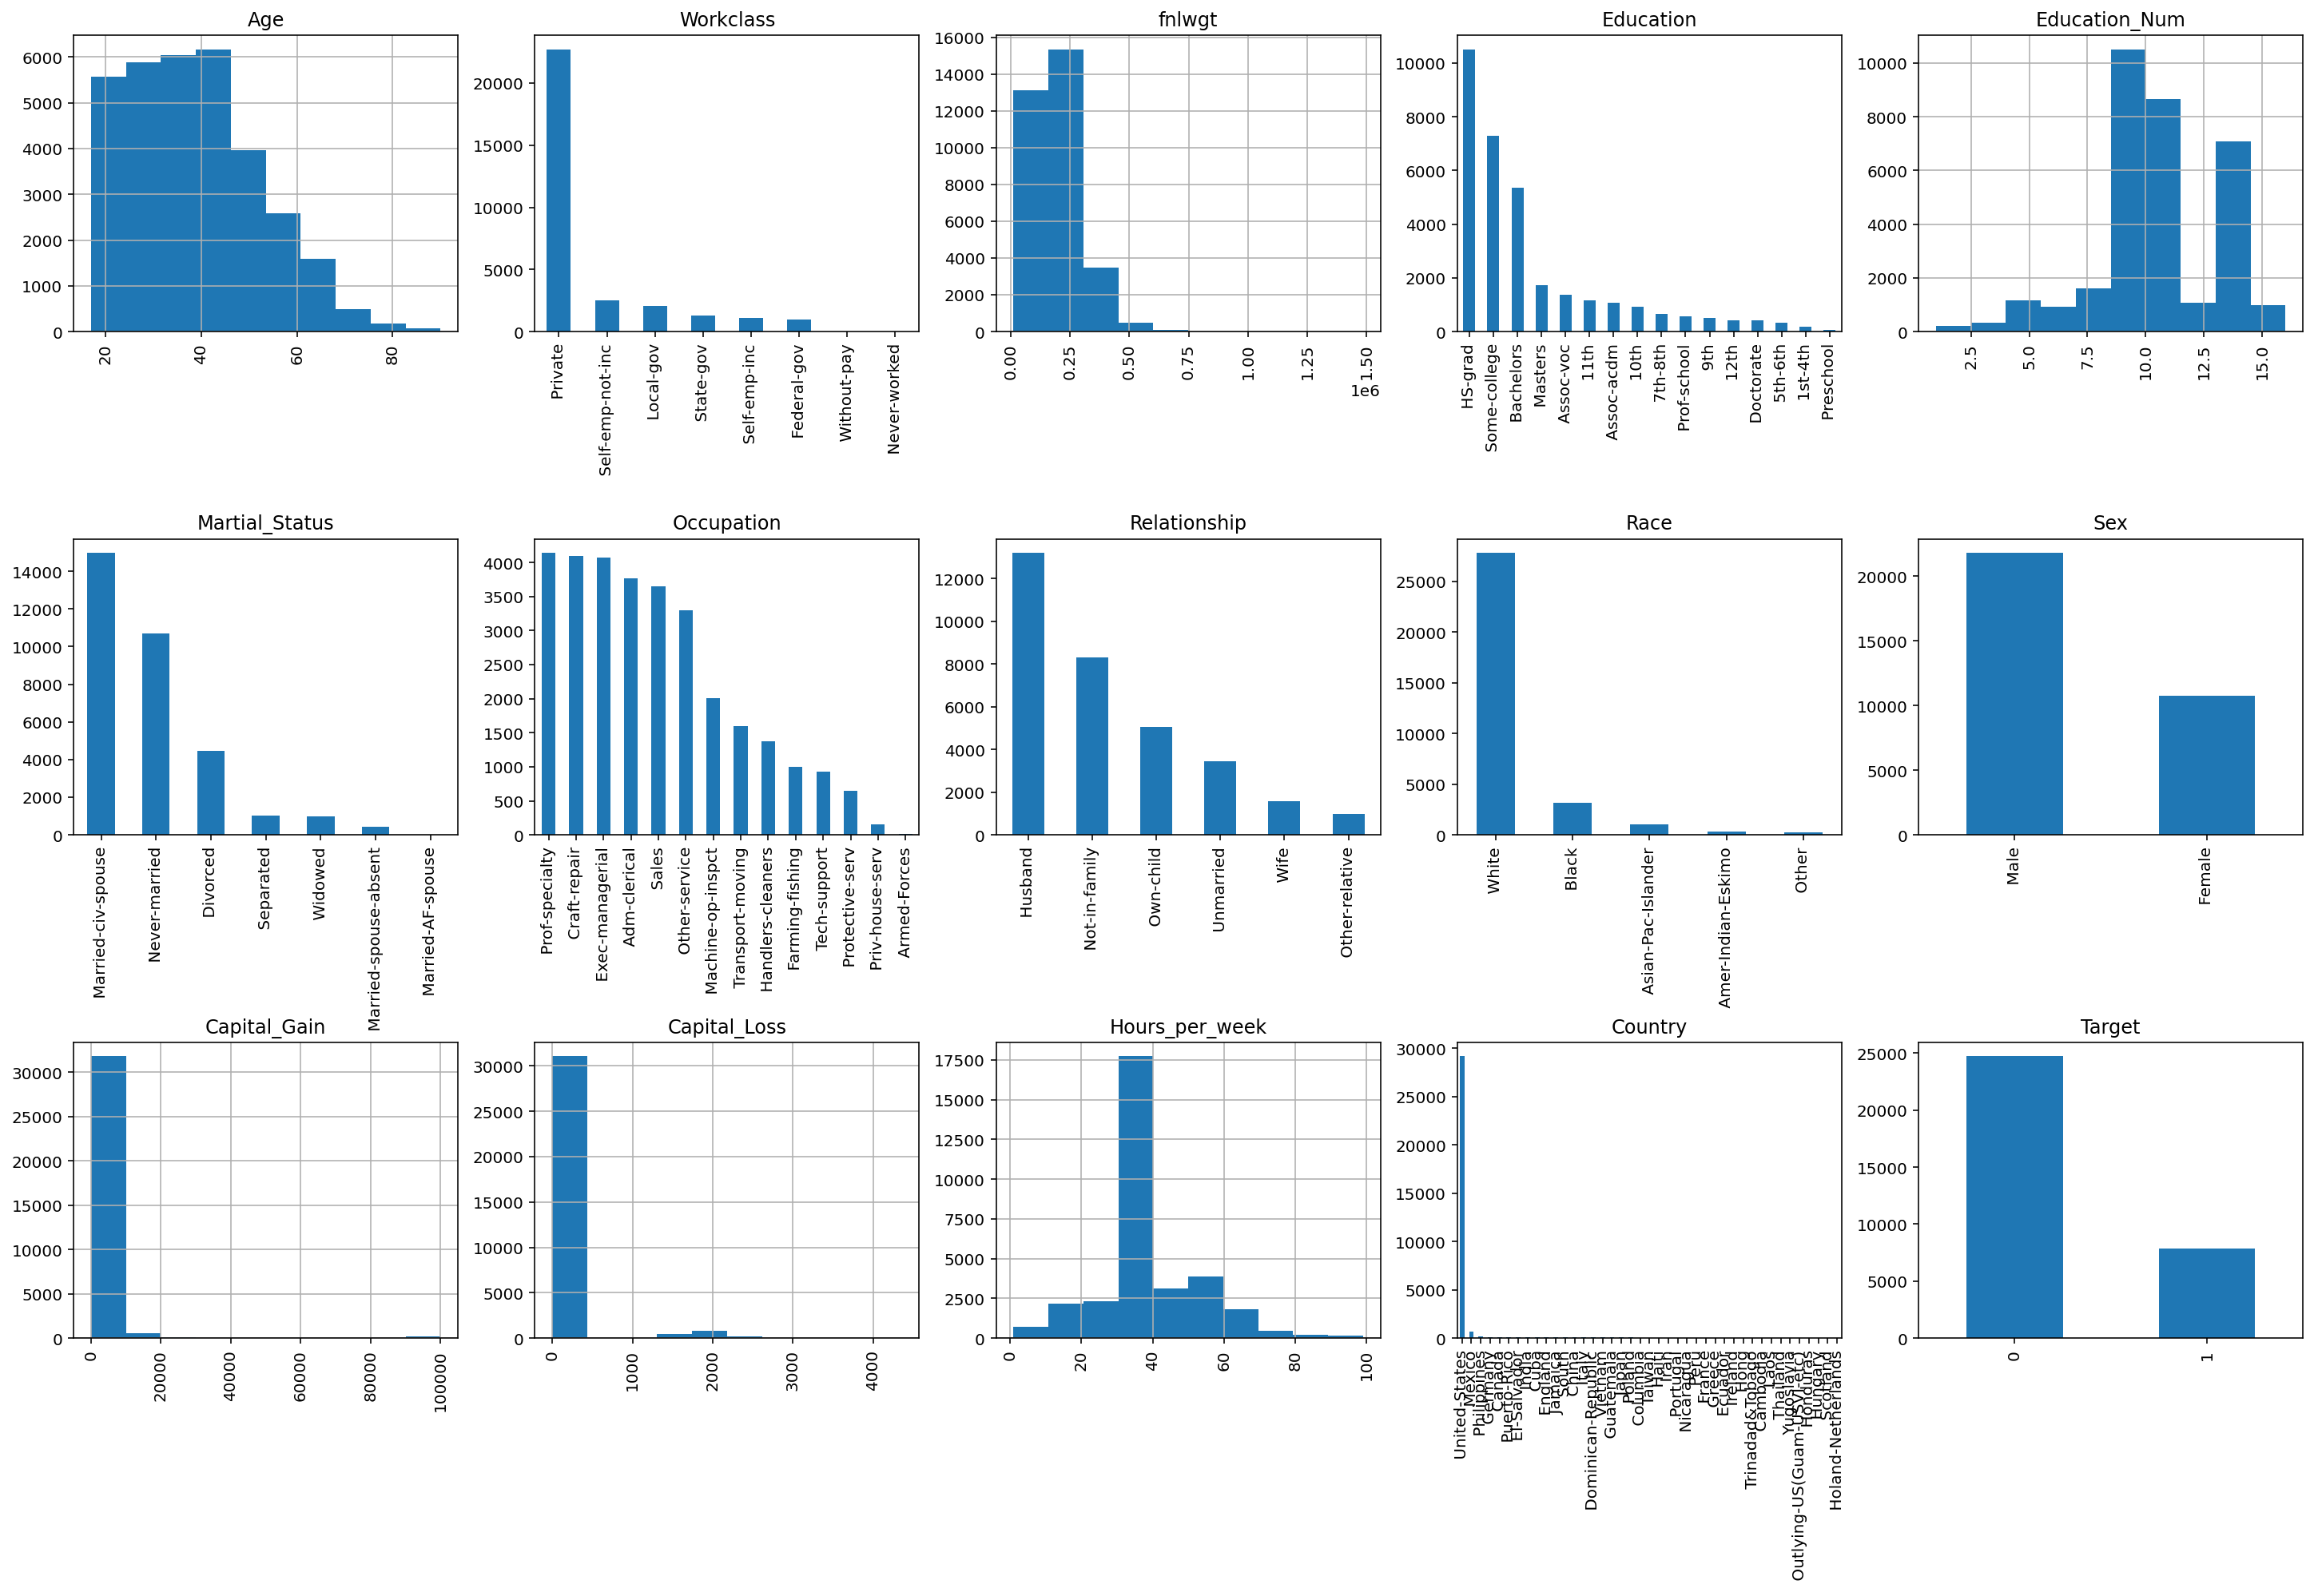

In [116]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = np.ceil(float(data_train.shape[1]) / cols)
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == np.object:
        data_train[column].value_counts().plot(kind='bar',
                                               axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation='vertical')
plt.subplots_adjust(hspace=0.7, wspace=0.2)

In [117]:
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target            object
dtype: object

In [118]:
data_test.dtypes

Age                object
Workclass          object
fnlwgt            float64
Education          object
Education_Num     float64
Martial_Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital_Gain      float64
Capital_Loss      float64
Hours_per_week    float64
Country            object
Target             object
dtype: object

In [120]:
data_test['Age'] = data_test['Age'].astype(int)

In [121]:
for column in data_test.columns:
    if data_test[column].dtype == 'float64':
        data_test[column] = data_test[column].astype(int)

In [122]:
data_train['Target'] = data_train['Target'].astype(int)
data_test['Target'] = data_test['Target'].astype(int)

In [123]:
data_test.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target             int64
dtype: object

In [124]:
categorical_columns = [c for c in data_train.columns
                       if data_train[c].dtype.name == 'object']
numerical_columns = [c for c in data_train.columns
                     if data_train[c].dtype.name != 'object']
print('categorical_columns:', categorical_columns)
print('numerical_columns:', numerical_columns)

categorical_columns: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']
numerical_columns: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week', 'Target']


In [125]:
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target             int64
dtype: object

In [126]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      30718 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         31978 non-null  object
 14  Target          32561 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


In [127]:
for c in categorical_columns:
    data_train[c].fillna(data_train[c].mode()[0], inplace=True)
    data_test[c].fillna(data_train[c].mode()[0], inplace=True)
    
for c in numerical_columns:
    data_train[c].fillna(data_train[c].median(), inplace=True)
    data_test[c].fillna(data_train[c].median(), inplace=True)

In [128]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      32561 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         32561 non-null  object
 14  Target          32561 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


In [129]:
data_train = pd.concat([data_train[numerical_columns],
                        pd.get_dummies(data_train[categorical_columns])], axis=1)

data_test = pd.concat([data_test[numerical_columns],
                       pd.get_dummies(data_test[categorical_columns])], axis=1)

In [130]:
set(data_train.columns) - set(data_test.columns)

{'Country_ Holand-Netherlands'}

In [131]:
data_train.shape, data_test.shape

((32561, 106), (16281, 105))

In [132]:
data_test['Country_ Holand-Netherlands'] = 0

In [133]:
set(data_train.columns) - set(data_test.columns)

set()

In [134]:
data_train.shape, data_test.shape

((32561, 106), (16281, 106))

In [135]:
data_train.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [136]:
data_test.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Country_ Holand-Netherlands
1,25,226802,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,38,89814,9,0,0,50,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [137]:
X_train = data_train.drop(['Target'], axis=1)
y_train = data_train['Target']

X_test = data_test.drop(['Target'], axis=1)
y_test = data_test['Target']

In [138]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=17)

In [139]:
tree_predictions = tree.predict(X_test)

In [140]:
accuracy_score(y_test, tree_predictions)

0.8447884036607088

In [141]:
tree_params = {'max_depth': range(2, 11)}

locally_best_tree = GridSearchCV(tree, tree_params, cv=5, n_jobs=-1, verbose=True)

locally_best_tree.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(max_depth=3, random_state=17),
             n_jobs=-1, param_grid={'max_depth': range(2, 11)}, verbose=True)

In [142]:
locally_best_tree.best_params_, locally_best_tree. best_score_

({'max_depth': 9}, 0.8565770273854106)

In [143]:
tuned_tree = DecisionTreeClassifier(max_depth=9, random_state=17)
tuned_tree.fit(X_train, y_train)
tuned_tree_predictions = tuned_tree.predict(X_test)
accuracy_score(y_test, tuned_tree_predictions)

0.847798046803022

In [144]:
rf = RandomForestClassifier(random_state=17)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
accuracy_score(y_test, rf_pred)

0.8585467723112831

In [145]:
forest_params = {'max_depth': range(10, 21),
                 'max_features': range(5, 105, 20)}

locally_best_forest = GridSearchCV(rf, forest_params, cv=5, n_jobs=-1, verbose=True)

locally_best_forest.fit(X_train, y_train)

Fitting 5 folds for each of 55 candidates, totalling 275 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=17), n_jobs=-1,
             param_grid={'max_depth': range(10, 21),
                         'max_features': range(5, 105, 20)},
             verbose=True)

In [146]:
locally_best_forest.best_params_, locally_best_forest.best_score_

({'max_depth': 19, 'max_features': 25}, 0.8651148562825209)

In [148]:
tuned_rf = RandomForestClassifier(max_depth=19, max_features=25, random_state=17)
tuned_rf.fit(X_train, y_train)
tuned_rf_pred = tuned_rf.predict(X_test)
accuracy_score(y_test, tuned_rf_pred)

0.8628462625145875